## Script for plotting spatial pattern 

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import seaborn as sns
from scipy.interpolate import make_interp_spline
from statsmodels.nonparametric.smoothers_lowess import lowess
import statsmodels.api as sm

import matplotlib.colors as mcolors

from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter1d
import matplotlib.patches as mpatches
from scipy.interpolate import griddata
from geopy.distance import geodesic

In [ ]:
d1 = pd.read_csv('siteA_output.csv')
d2 = pd.read_csv('siteB_output.csv')
d3 = pd.read_csv('siteC_output.csv')
d4 = pd.read_csv('siteD_output.csv')

## Part I: Compare spatial distribution, NO2 conc & Per capita mortality Vs. distance

### [1] Site A

/var/folders/pt/8kzg0v317_n0vtkkr_rslmy80000gp/T/ipykernel_10076/2304107662.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data = sbn_test.groupby('distance_bin').agg({'Per_Cap_Mort': 'mean'}).reset_index()


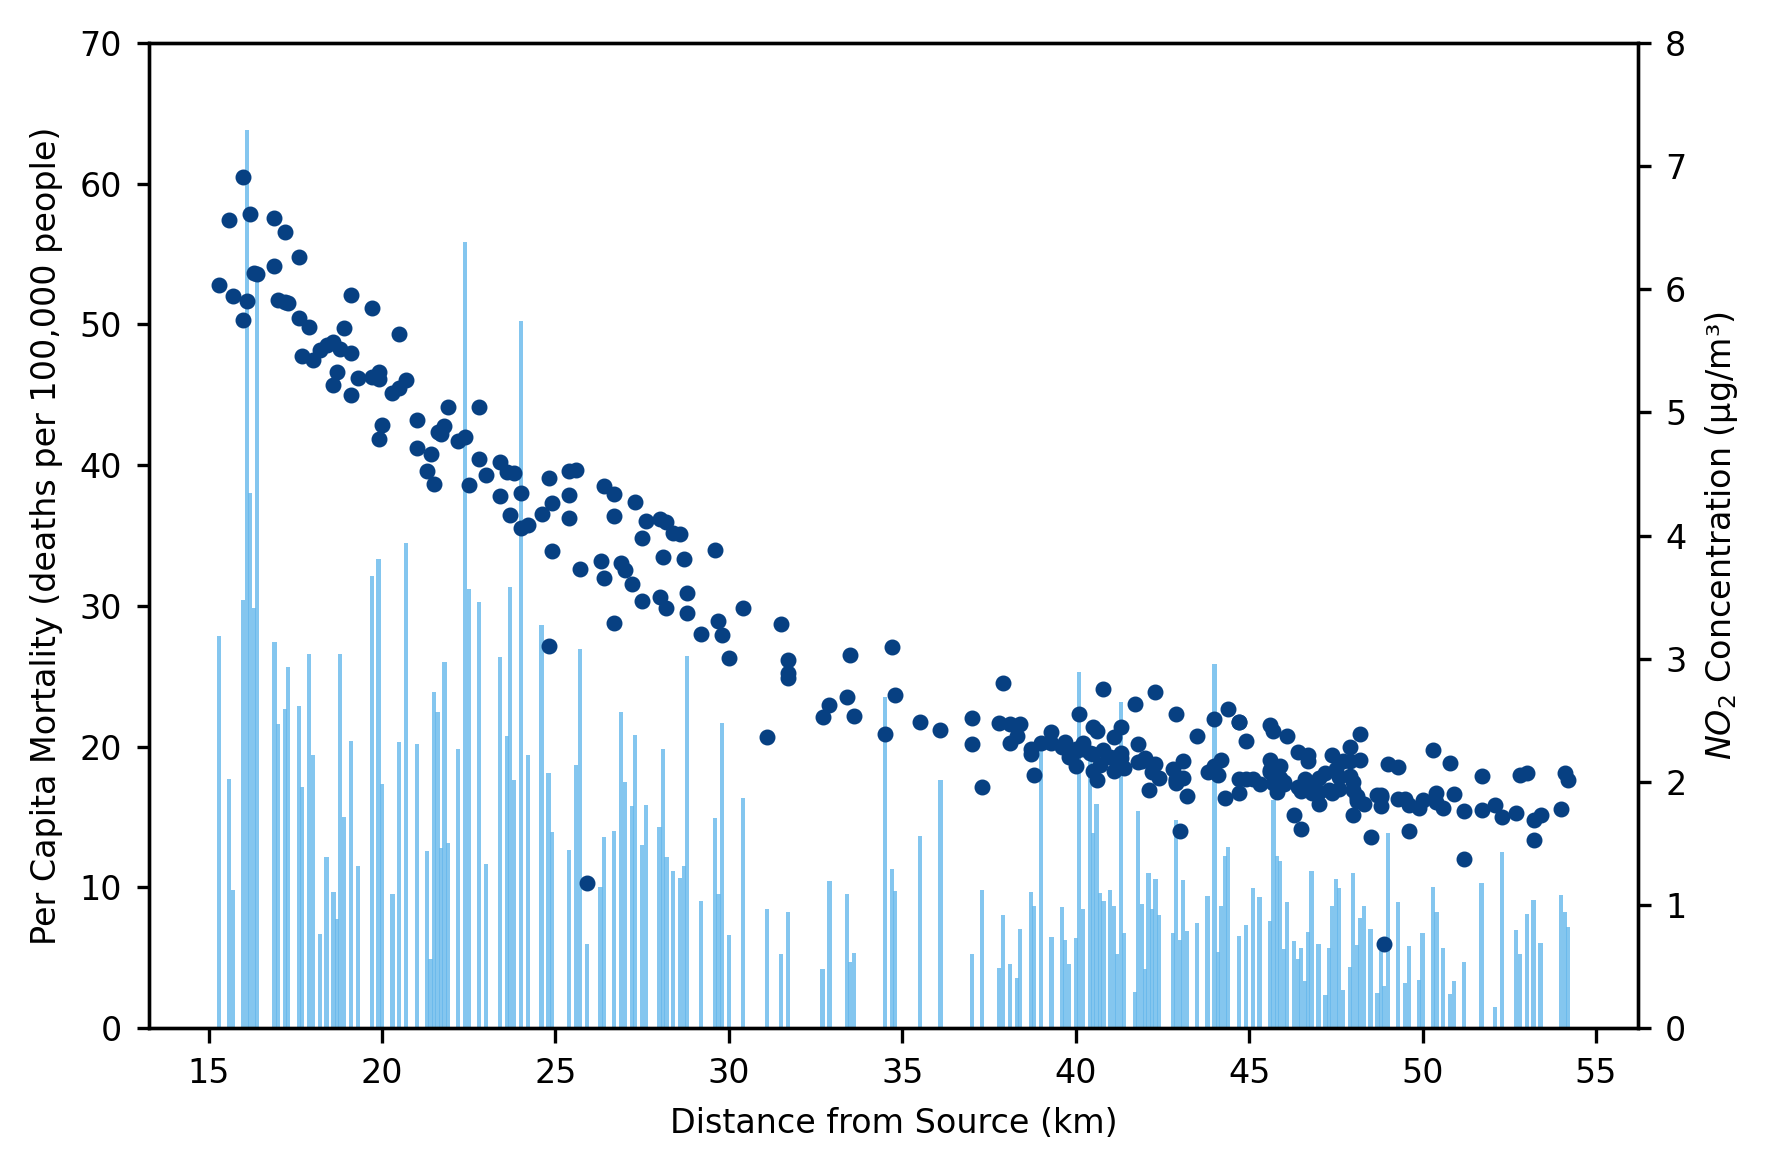

In [24]:
# Bin distances (for histogram)
bin_size = 0.1  # Adjust bin width
bins = np.arange(0, 60, bin_size)  # Binning from 0 to 55 km
d1['distance_bin'] = pd.cut(d1['distance_km'], bins=bins, labels=bins[:-1])

# Compute mean NO2 for each bin
binned_data = d1.groupby('distance_bin').agg({'Per_Cap_Mort': 'mean'}).reset_index()
binned_data['distance_bin'] = binned_data['distance_bin'].astype(float)

# Convert to float and drop NaN values
binned_data['distance_bin'] = binned_data['distance_bin'].astype(float)
#binned_data = binned_data.dropna(subset=['Annual_Ave'])  # Drop rows with NaN

# Plot
fig, ax1 = plt.subplots(figsize=(6, 4),dpi=300)


# Per Capita Mortality Histogram (right y-axis)
ax1.set_xlabel('Distance from Source (km)',size = 8)
ax1.bar(binned_data['distance_bin'], binned_data['Per_Cap_Mort'], width=bin_size * 1.2, color='#66b8ec', alpha=0.8, label='Per Capita Mortality')
ax1.set_ylabel('Per Capita Mortality (deaths per 100,000 people)', color='k',size = 8)
ax1.tick_params(axis='y', labelcolor='k',size = 3, labelsize=8)
ax1.tick_params(axis='x', labelsize=8)  # Adjust labelsize here for x-axis
ax1.set_ylim(0, 70)

# NO2 Concentration Curve (left y-axis)
ax2 = ax1.twinx()
ax2.scatter(sbn_test['distance_bin'], sbn_test['Annual_Ave'], color='#074082', label='NO2 Concentration', s=8)
ax2.set_ylabel('$NO_2$ Concentration (µg/m³)', color='k',size = 8)
ax2.tick_params(axis='y', labelcolor='k', size = 3, labelsize=8)
ax2.set_ylim(0, 8)

# Show plot
fig.tight_layout()
plt.show()

In [3]:
from shapely import wkt

d1['geometry'] = d1['geometry'].apply(wkt.loads)

# Create a GeoDataFrame
d1_gdf = gpd.GeoDataFrame(d1, geometry='geometry')

# Set the CRS (adjust EPSG code as needed)
d1_gdf.set_crs("EPSG:4269", inplace=True)

,Unnamed: 0.1,Unnamed: 0,TRACTCE,0_0MR,15_24MR,1_4MR,25_34MR,35_44MR,45_54MR,55_64MR,...,25_34Mort,35_44Mort,45_54Mort,55_64Mort,65_74Mort,75_84Mort,85_99Mort,Annual_Ave,ElderlyPOP,ElderlyPOP_PCT
0,0,0,313,0.009352,0.001415,0.001534,0.000356,0.001043,0.003138,0.003494,...,0.000281,0.000045,0.001754,0.003705,0.009631,0.000000,0.000000,1.833644,114,0.250000
1,1,1,312,0.009352,0.001415,0.001534,0.000356,0.001043,0.003138,0.003494,...,0.000749,0.002061,0.007868,0.007442,0.006834,0.009692,0.027152,1.786951,175,0.092642
2,2,2,20300,0.009585,0.000853,0.000427,0.001546,0.002923,0.006801,0.014166,...,0.005300,0.004414,0.005195,0.021642,0.036375,0.043737,0.037285,2.222825,269,0.173436
3,3,3,20500,0.010989,0.000950,0.000532,0.001459,0.002813,0.006711,0.011073,...,0.001356,0.002059,0.006643,0.006100,0.011946,0.000000,0.009797,2.204343,72,0.081725
4,4,4,20500,0.010989,0.000950,0.000532,0.001459,0.002813,0.006711,0.011073,...,0.001439,0.004634,0.016702,0.006013,0.018164,0.031151,0.000000,2.318097,152,0.138434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,273,274,21902,0.003418,0.000528,0.000736,0.002149,0.000878,0.003026,0.008414,...,0.005987,0.000298,0.003950,0.011849,0.008972,0.000000,0.000000,2.634472,44,0.031815
274,274,275,3400,0.013113,0.001452,0.000823,0.001946,0.004161,0.006461,0.013842,...,0.001047,0.005061,0.006850,0.002384,0.015205,0.007858,0.019278,1.375951,153,0.127288
275,275,276,970202,0.006020,0.000987,0.000340,0.001813,0.002130,0.004287,0.009332,...,0.000075,0.000000,0.000455,0.002886,0.009256,0.001461,0.000000,1.179641,104,0.436975
276,276,277,970203,0.006020,0.000987,0.000340,0.001813,0.002130,0.004287,0.009332,...,0.000247,0.000519,0.001342,0.001623,0.000055,0.008467,0.006570,0.683083,75,0.116641


In [ ]:
# Plot the concentration data on the block groups
fig, ax = plt.subplots(figsize=(10, 10),dpi=300)

# Create fixed boundaries
boundaries = [ 10, 15, 20, 25, 30, 35,40, 75]

# Create a custom colormap with 10 discrete shades of Purples
blues = plt.cm.Blues(np.linspace(0.1, 0.9,7))  # Custom range
custom_cmap = mcolors.ListedColormap(blues)  # Convert to discrete colormap

# Plot block groups with mortality
d1_gdf.plot(column='Per_Cap_Mort', ax=ax, #legend=True, 
             cmap=custom_cmap,
             scheme='user_defined',
             classification_kwds={'bins': boundaries}, 
             edgecolor="dimgrey", linewidth=0.05) #,vmin=vmin, vmax=vmax)

# Customize the plot
ax.set_title('NO₂-Attributable Per Captita Mortality at Block Group level, Site A')
ax.set_axis_off()

plt.show()

### [2] Site B

/var/folders/pt/8kzg0v317_n0vtkkr_rslmy80000gp/T/ipykernel_10076/578849513.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data2 = cmrn_test.groupby('distance_bin').agg({'Annual_Ave': 'mean', 'Per_Cap_Mort': 'mean'}).reset_index()
/var/folders/pt/8kzg0v317_n0vtkkr_rslmy80000gp/T/ipykernel_10076/578849513.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data2_2 = cmrn_test.groupby('distance_bin').agg({'Annual_Ave': 'mean'}).reset_index()


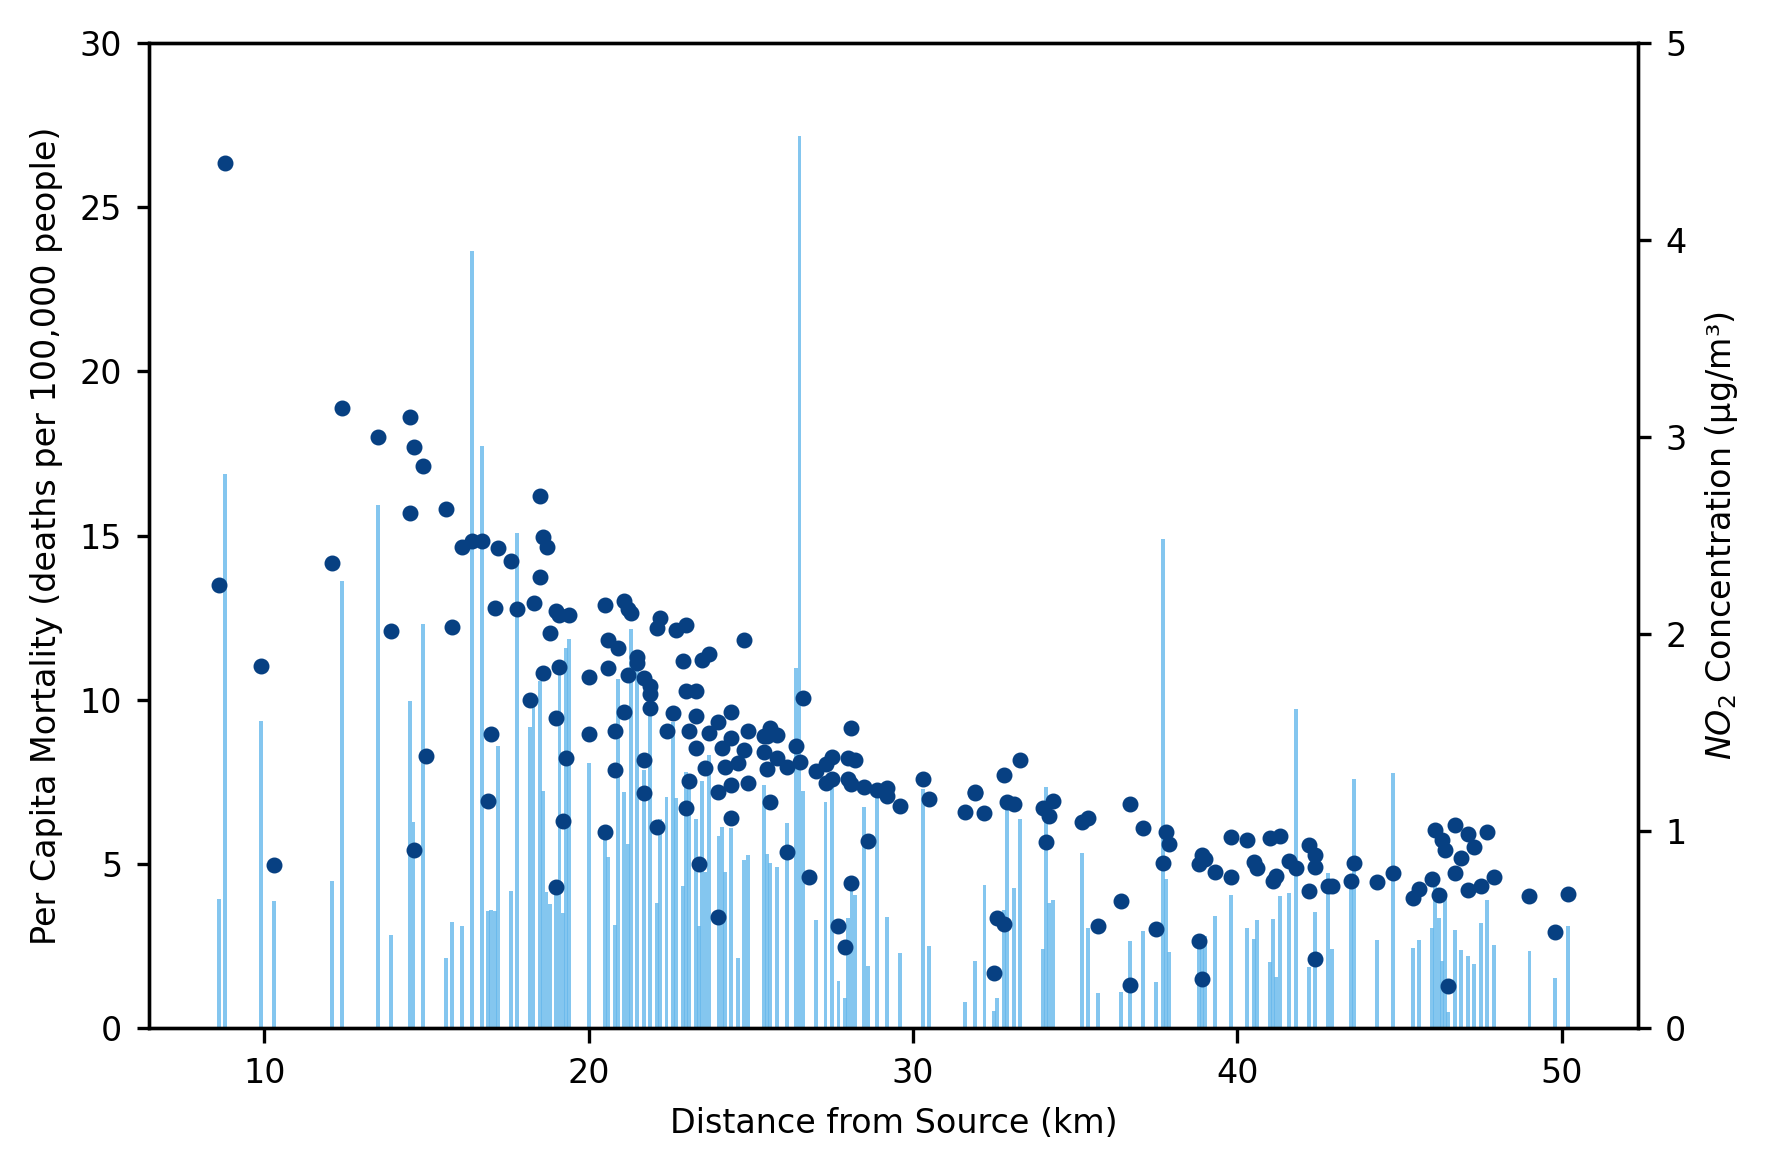

In [19]:
# Bin distances (for histogram)
bin_size = 0.1  # Adjust bin width
bins = np.arange(0, 60, bin_size)  # Binning from 0 to 55 km
d2['distance_bin'] = pd.cut(d2['distance_km'], bins=bins, labels=bins[:-1])

# Compute mean NO2 for each bin
binned_data2 = d2.groupby('distance_bin').agg({'Annual_Ave': 'mean', 'Per_Cap_Mort': 'mean'}).reset_index()
binned_data2['distance_bin'] = binned_data2['distance_bin'].astype(float)

# Convert to float and drop NaN values
binned_data2 = binned_data2.dropna(subset=['Annual_Ave'])  # Drop rows with NaN

binned_data2_2 = cmrn_test.groupby('distance_bin').agg({'Annual_Ave': 'mean'}).reset_index()
binned_data2_2['distance_bin'] = binned_data2_2['distance_bin'].astype(float)

# Apply LOESS smoothing for NO2 concentration
frac = 0.15  # Adjust fraction for smoothness (higher = smoother)
smoothed_no2_2 = lowess(binned_data2_2['Annual_Ave'], binned_data2_2['distance_bin'], frac=frac)[:, 1]

# Plot
fig, ax1 = plt.subplots(figsize=(6, 4),dpi=300)


# Per Capita Mortality Histogram (right y-axis)
ax1.set_xlabel('Distance from Source (km)',size = 8)
ax1.bar(binned_data2['distance_bin'], binned_data2['Per_Cap_Mort'], width=bin_size * 1.2, color='#66b8ec', alpha=0.8, label='Per Capita Mortality')
ax1.set_ylabel('Per Capita Mortality (deaths per 100,000 people)', color='k',size = 8)
ax1.tick_params(axis='y', labelcolor='k',size = 3, labelsize=8)
ax1.tick_params(axis='x', labelsize=8)  # Adjust labelsize here for x-axis
ax1.set_ylim(0, 30)

# NO2 Concentration Curve (left y-axis)
ax2 = ax1.twinx()
ax2.scatter(cmrn_test['distance_bin'], cmrn_test['Annual_Ave'], color='#074082', label='NO2 Concentration', s=8)
ax2.set_ylabel('$NO_2$ Concentration (µg/m³)', color='k',size = 8)
ax2.tick_params(axis='y', labelcolor='k', size = 3, labelsize=8)
ax2.set_ylim(0, 5)

# Show plot
fig.tight_layout()
plt.show()

In [ ]:
### from shapely import wkt

d2['geometry'] = d2['geometry'].apply(wkt.loads)

# Create a GeoDataFrame
d2_gdf = gpd.GeoDataFrame(d2, geometry='geometry')

# Set the CRS (adjust EPSG code as needed)
d2_gdf.set_crs("EPSG:4269", inplace=True)

In [ ]:
# Plot the concentration data on the block groups
fig, ax = plt.subplots(figsize=(10, 10),dpi=300)

# Create fixed boundaries
boundaries = [5,10,15,20,25,30]

# Create a custom colormap with 10 discrete shades of Purples
blues = plt.cm.Blues(np.linspace(0.1, 0.9,6))  # Custom range
custom_cmap = mcolors.ListedColormap(blues)  # Convert to discrete colormap


# Plot block groups with mortality

d2_gdf.plot(column='Per_Cap_Mort', ax=ax, #legend=True, 
             cmap=custom_cmap,
             scheme='user_defined',
             classification_kwds={'bins': boundaries}, 
             edgecolor="dimgrey", linewidth=0.05) #,vmin=vmin, vmax=vmax)

# Customize the plot
ax.set_title('NO₂-Attributable Mortality at Block Group level, Site B')
ax.set_axis_off()

plt.show()

### [3] Site C

/var/folders/pt/8kzg0v317_n0vtkkr_rslmy80000gp/T/ipykernel_10076/1444181478.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data3 = cps_test.groupby('distance_bin').agg({'Per_Cap_Mort': 'mean'}).reset_index()


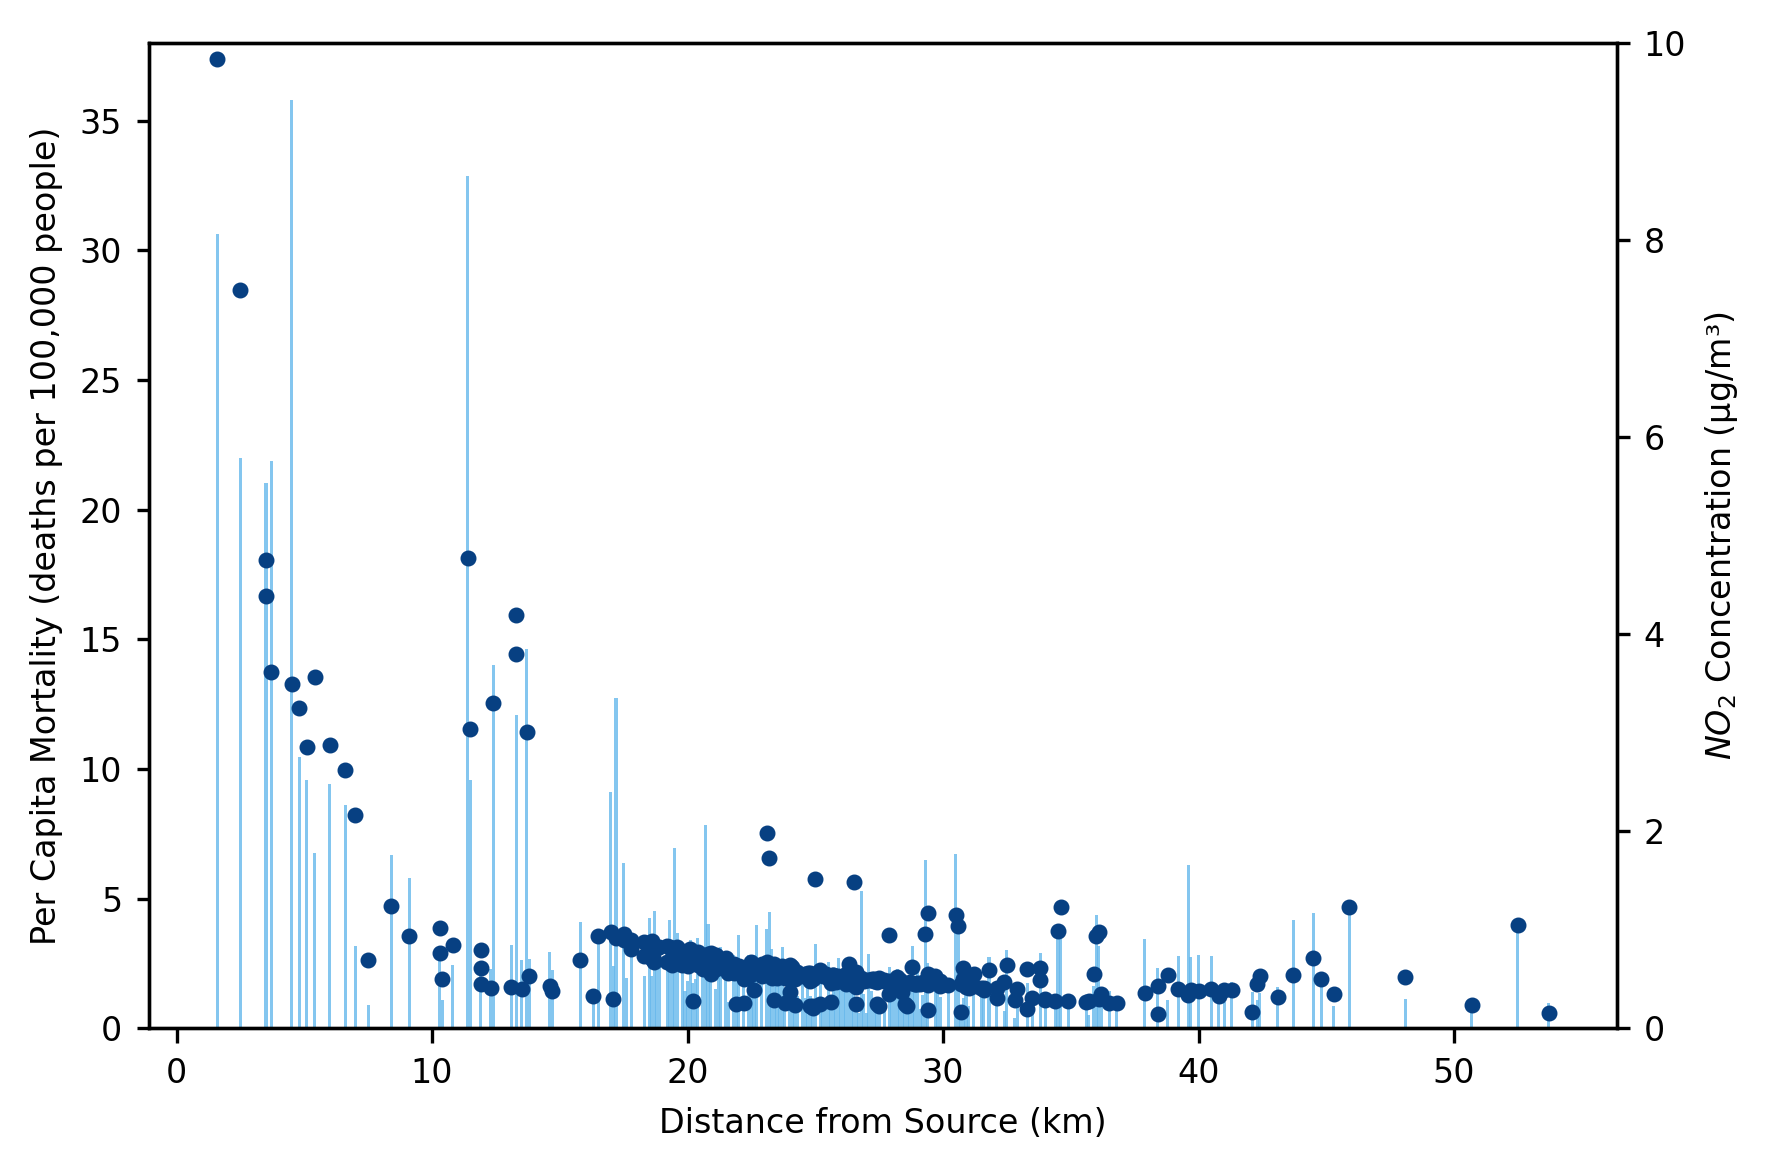

In [42]:
# Bin distances (for histogram)
bin_size = 0.1  # Adjust bin width
bins = np.arange(0, 60, bin_size)  # Binning from 0 to 55 km
d3['distance_bin'] = pd.cut(d3['distance_km'], bins=bins, labels=bins[:-1])

# Compute mean MR for each bin
binned_data3 = d3.groupby('distance_bin').agg({'Per_Cap_Mort': 'mean'}).reset_index()
binned_data3['distance_bin'] = binned_data3['distance_bin'].astype(float)


# Plot
fig, ax1 = plt.subplots(figsize=(6, 4),dpi=300)


# Per Capita Mortality Histogram (right y-axis)
ax1.set_xlabel('Distance from Source (km)',size = 8)
ax1.bar(binned_data3['distance_bin'], binned_data3['Per_Cap_Mort'], width=bin_size * 1.2, color='#66b8ec', alpha=0.8, label='Per Capita Mortality')
ax1.set_ylabel('Per Capita Mortality (deaths per 100,000 people)', color='k',size = 8)
ax1.tick_params(axis='y', labelcolor='k',size = 3, labelsize=8)
ax1.tick_params(axis='x', labelsize=8)  # Adjust labelsize here for x-axis
ax1.set_ylim(0, 38)

# NO2 Concentration Curve (left y-axis)
ax2 = ax1.twinx()
ax2.scatter(cps_test['distance_bin'], cps_test['Annual_Ave'], color='#074082', label='NO2 Concentration', s=8)
ax2.set_ylabel('$NO_2$ Concentration (µg/m³)', color='k',size = 8)
ax2.tick_params(axis='y', labelcolor='k', size = 3, labelsize=8)
ax2.set_ylim(0, 10)

# Show plot
fig.tight_layout()
plt.show()

In [ ]:
from shapely import wkt

# Create a GeoDataFrame
d3_gdf = gpd.GeoDataFrame(d3, geometry='geometry_y')

# Set the CRS (adjust EPSG code as needed)
d3_gdf.set_crs("EPSG:4269", inplace=True)

In [ ]:
# Plot the concentration data on the block groups
fig, ax = plt.subplots(figsize=(10, 10),dpi=300)

# Create fixed boundaries
boundaries = [4,8,12,16,20,40]

# Create a custom colormap with 10 discrete shades of Purples
blues = plt.cm.Blues(np.linspace(0.1, 0.9,6))  # Custom range
custom_cmap = mcolors.ListedColormap(blues)  # Convert to discrete colormap


# Plot block groups with mortality

d3_gdf.plot(column='Per_Cap_Mort', ax=ax, legend=True, 
             cmap=custom_cmap,
             scheme='user_defined',
             classification_kwds={'bins': boundaries}, 
             edgecolor="dimgrey", linewidth=0.05) #,vmin=vmin, vmax=vmax)

# Customize the plot
ax.set_title('NO₂-Attributable Mortality at Block Group level, Site C')
ax.set_axis_off()

plt.show()

### [4] Site D

/var/folders/pt/8kzg0v317_n0vtkkr_rslmy80000gp/T/ipykernel_10076/1389396111.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data4 = fpt_test.groupby('distance_bin').agg({'Per_Cap_Mort': 'mean'}).reset_index()


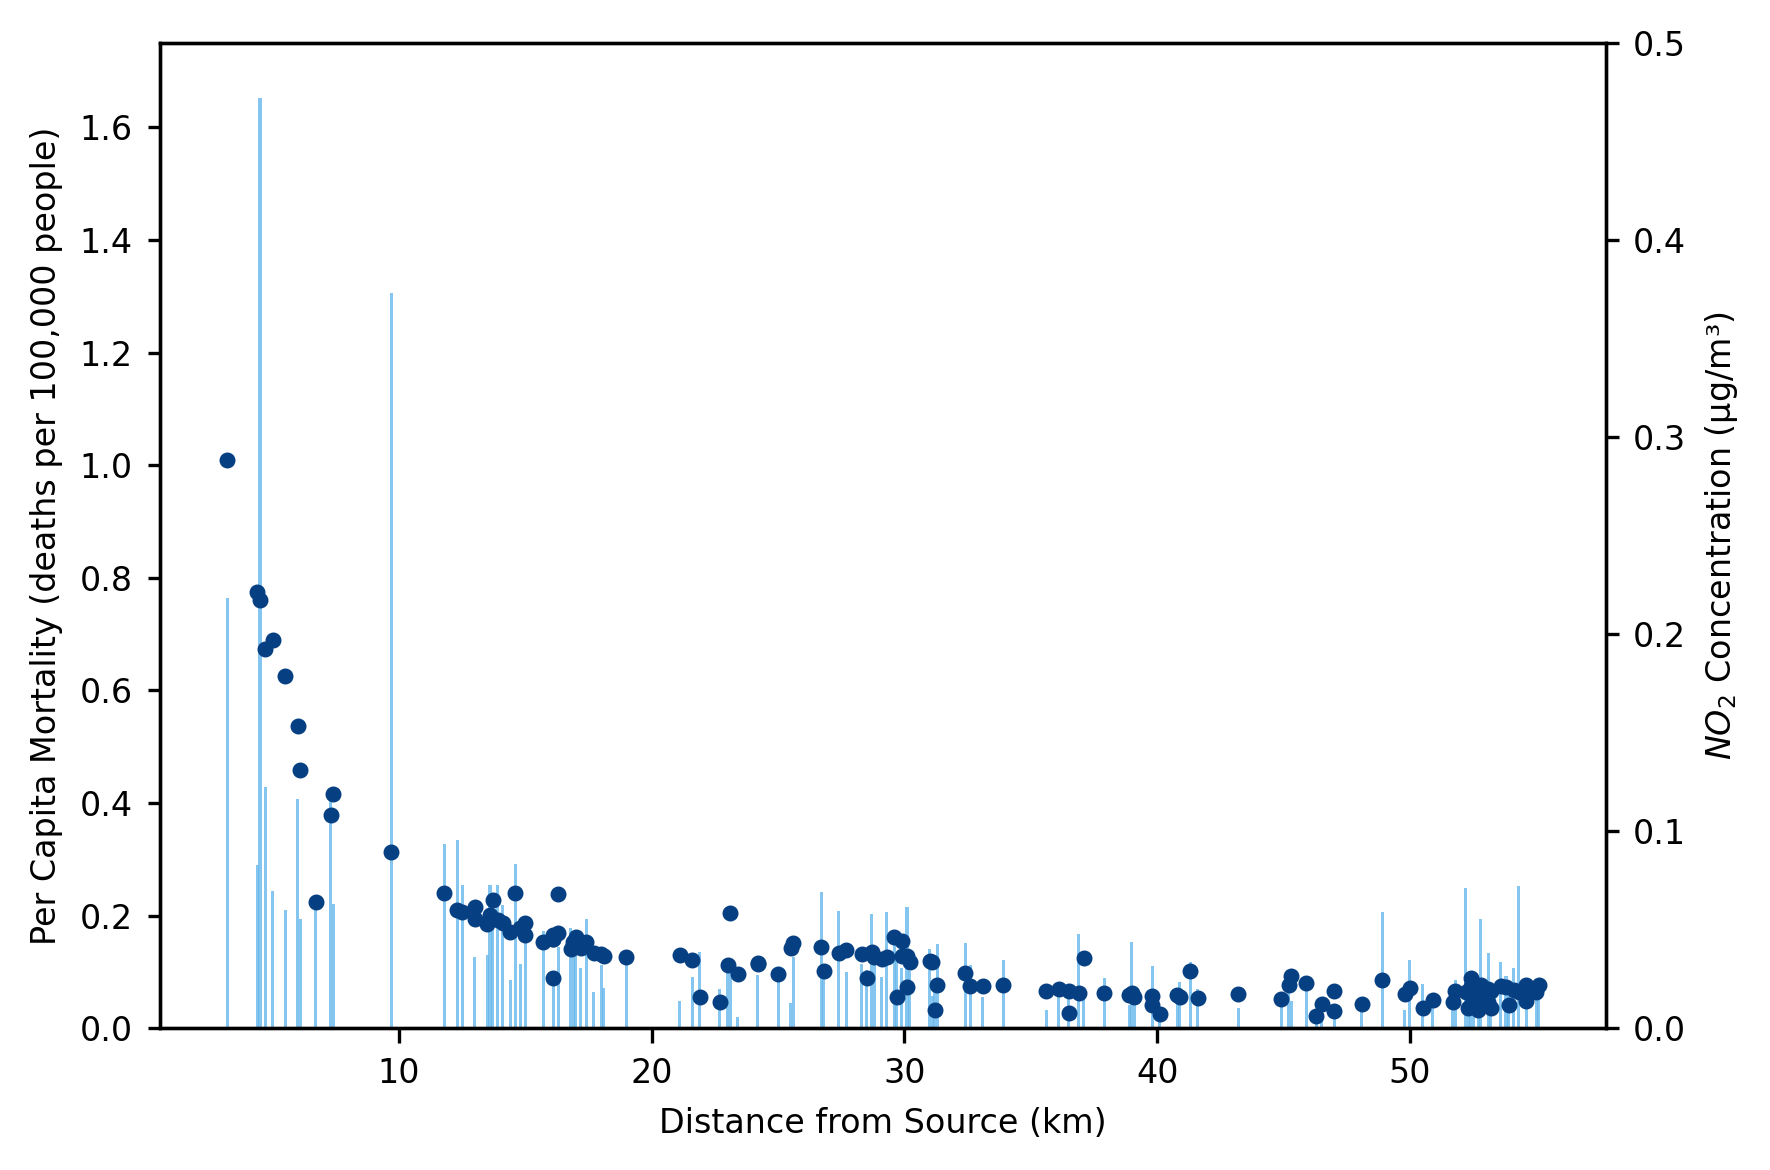

In [37]:
# Bin distances (for histogram)
bin_size = 0.1  # Adjust bin width
bins = np.arange(0, 60, bin_size)  # Binning from 0 to 55 km
d4['distance_bin'] = pd.cut(d4['distance_km'], bins=bins, labels=bins[:-1])

# Compute mean NO2 for each bin
binned_data4 = d4.groupby('distance_bin').agg({'Per_Cap_Mort': 'mean'}).reset_index()
binned_data4['distance_bin'] = binned_data4['distance_bin'].astype(float)

# Convert to float and drop NaN values
#binned_data4 = binned_data4.dropna(subset=['Annual_Ave'])  # Drop rows with NaN

# Plot
fig, ax1 = plt.subplots(figsize=(6, 4),dpi=300)


# Per Capita Mortality Histogram (right y-axis)
ax1.set_xlabel('Distance from Source (km)',size = 8)
ax1.bar(binned_data4['distance_bin'], binned_data4['Per_Cap_Mort'], width=bin_size * 1.2, color='#66b8ec', alpha=0.8, label='Per Capita Mortality')
ax1.set_ylabel('Per Capita Mortality (deaths per 100,000 people)', color='k',size = 8)
ax1.tick_params(axis='y', labelcolor='k',size = 3, labelsize=8)
ax1.tick_params(axis='x', labelsize=8)  # Adjust labelsize here for x-axis
ax1.set_ylim(0, 1.75)

# NO2 Concentration Curve (left y-axis)
ax2 = ax1.twinx()
ax2.scatter(fpt_test['distance_bin'], fpt_test['Annual_Ave'], color='#074082', label='NO2 Concentration', s=8)
ax2.set_ylabel('$NO_2$ Concentration (µg/m³)', color='k',size = 8)
ax2.set_ylabel('$NO_2$ Concentration (µg/m³)', color='k',size = 8)
ax2.tick_params(axis='y', labelcolor='k', size = 3, labelsize=8)
ax2.set_ylim(0, 0.5)

# Show plot
fig.tight_layout()
plt.show()

In [ ]:
### from shapely import wkt

d4['geometry'] = d4['geometry'].apply(wkt.loads)

# Create a GeoDataFrame
d4_gdf = gpd.GeoDataFrame(d4, geometry='geometry')

# Set the CRS (adjust EPSG code as needed)
d4_gdf.set_crs("EPSG:4269", inplace=True)

In [ ]:
# Plot the concentration data on the block groups
fig, ax = plt.subplots(figsize=(10, 10),dpi=300)

# Create fixed boundaries
boundaries = [0.1,0.2,0.4,0.6,1]

# Create a custom colormap with 10 discrete shades of Purples
blues = plt.cm.Blues(np.linspace(0.1, 0.6,6))  # Custom range
custom_cmap = mcolors.ListedColormap(blues)  # Convert to discrete colormap


# Plot block groups with mortality

d4_gdf.plot(column='Per_Cap_Mort', ax=ax, #legend=True, 
             cmap=custom_cmap,
             scheme='user_defined',
             classification_kwds={'bins': boundaries}, 
             edgecolor="dimgrey", linewidth=0.05) #,vmin=vmin, vmax=vmax)

# Customize the plot
ax.set_title('NO₂-Attributable Mortality at Block Group level, Site D')
ax.set_axis_off()

plt.show()